<a href="https://colab.research.google.com/github/zavavan/case-2021-shared-task/blob/main/EmbeddingClusteringWithUMAP_Hdbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [3]:
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

In [4]:
!pip install openpyxl
!pip install XlsxWriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from itertools import compress

from numpy import asarray
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from itertools import compress
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.datasets import fetch_openml
import getpass
import logging

!pip install umap-learn
!pip install hdbscan
# Dimension reduction and clustering libraries
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from sklearn.model_selection import GridSearchCV



In [115]:
import csv

In [6]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# to make this notebook's output stable across runs
np.random.seed(42)
import warnings
warnings.simplefilter(action='ignore')

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

!pip -q install scikit-learn-extra > log


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [7]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


In [8]:
def save_fig(fig_id, path, tight_layout=True, fig_extension="png", resolution=600):
    IMAGES_PATH = os.path.join(path, "images")
    os.makedirs(IMAGES_PATH, exist_ok=True)
    concatenated_path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(concatenated_path, format=fig_extension, dpi=resolution)

In [9]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [10]:
import warnings
warnings.simplefilter(action='ignore')

In [184]:
test_folder = '/content/drive/MyDrive/Colab Notebooks'
result_folder = '/content/drive/MyDrive/Colab Notebooks/clustering'
shared_folder = '/content/drive/MyDrive/PhDThesis/Twitter'
clustering_shared_folder = '/content/drive/MyDrive/PhDThesis/Twitter/clustering'
base_folder= '/content/drive/MyDrive/Colab Notebooks/resultsNewsCorpus'
tensor_folder= '/content/drive/MyDrive/Colab Notebooks/results100kSample_multitoken/tensors_chunks/bert'
relations_folder= '/content/drive/MyDrive/Colab Notebooks/results100kSample_multitoken/relations_chunks'

##rebuild glove tensors and relations from file ##

In [12]:
#glove_tensors = torch.load(os.path.join(test_folder,'glove_tensors_1k_news.pt'))
glove_tensors = torch.load(os.path.join(test_folder,'glove_tensors_100k_tweets.pt'))

In [13]:
#glove_relations = pd.read_csv(os.path.join(test_folder,'relations_news_1k_glove_.csv'), header=0, index_col=0)
glove_relations = pd.read_csv(os.path.join(test_folder,'relations_tweets_100k_glove_.csv'), header=0, index_col=0)

In [14]:
print(len(glove_relations))
print(len(glove_tensors))

29209
29209


In [15]:
glove_relations['glove_embeddings']=glove_tensors

In [16]:
glove_relations.head()

,RelationHead,RelationHeadLemma,DocIndex,TokenIndex,glove_embeddings
0,converging,converge,1,[6],"[-3.0448, 1.6889, -2.0189, 0.83227, 2.0169, 0...."
1,taking,take,7,[3],"[3.3667, -4.2011, -4.0966, -2.6492, 1.5651, 0...."
2,go,go,27,[3],"[1.484, 8.3944, -8.3806, 3.2081, -4.2582, 1.97..."
3,face,face,28,[3],"[2.6234, 3.2451, -4.9375, 1.6368, 3.6953, 2.61..."
4,spur,spur,30,[4],"[-2.0217, 3.3765, 0.6967, -0.88704, 1.1327, -1..."


##rebuild BERT tensors and relations from chuncked files ##

In [17]:
bert_relations = pd.DataFrame(columns=['RelationHead', 'RelationHeadLemma','DocIndex', 'TokenIndex'])
# Iterate directory
for file in os.listdir(relations_folder):
    # check only text files
    if file.endswith('.csv'):
        #print(os.path.join(dir_path,file))
        df = pd.read_csv(os.path.join(relations_folder,file), header=0, index_col=0)
        #print(df)
        bert_relations = pd.concat([bert_relations, df], axis=0)

#bert_relations.to_csv(os.path.join(test_folder,'RelationsNews100docs_rebuilt.csv'), encoding="utf-8")

In [18]:
bert_tensors = []
# Iterate directory
for file in os.listdir(tensor_folder):
    # check only text files
    if file.endswith('.pt'):
        #print(os.path.join(dir_path,file))
        bert_tensors.extend(torch.load(os.path.join(tensor_folder,file)))

In [19]:
print(len(bert_relations))
print(len(bert_tensors))

29335
29335


## apply normalization to vectors before applying dimensionality reduction ##

In [20]:
## glove vectors

scaler = MinMaxScaler()

normalized_glove_tensors = []
numpy_array_vecs = []

# convert tensors to numpy arrays
for vec in glove_tensors:
  #print(vec.shape)
  #here I need to convert first from torch to np array
  numpy_array_vecs.append(vec)

# transform data
scaled_numpy_array_vecs = scaler.fit_transform(numpy_array_vecs)


for scaled_numpy_array_vec in scaled_numpy_array_vecs:
  normalized_glove_tensors.append(torch.from_numpy(scaled_numpy_array_vec))


numpy_normalized_glove_tensors = [np.array(x) for x in normalized_glove_tensors]


In [21]:
## BERT vectors

scaler = MinMaxScaler()

normalized_bert_tensors = []
numpy_array_vecs = []

# convert tensors to numpy arrays
for vec in bert_tensors:
  #print(vec.shape)
  #here I need to convert first from torch to np array
  numpy_array_vecs.append(vec.numpy())

# transform data
scaled_numpy_array_vecs = scaler.fit_transform(numpy_array_vecs)


for scaled_numpy_array_vec in scaled_numpy_array_vecs:
  normalized_bert_tensors.append(torch.from_numpy(scaled_numpy_array_vec))


numpy_normalized_bert_tensors = [np.array(x) for x in normalized_bert_tensors]



## apply standadization to torch vectors before applying dimensionality reduction ##

---



In [22]:
## glove vectors

scaler = StandardScaler()

standardized_glove_tensors = []
numpy_array_vecs = []

# convert tensors to numpy arrays
for vec in glove_tensors:
  #numpy_array_vecs.append(vec.numpy())
  numpy_array_vecs.append(vec)

# transform data
norm_numpy_array_vecs = scaler.fit_transform(numpy_array_vecs)


for norm_numpy_array_vec in norm_numpy_array_vecs:
  standardized_glove_tensors.append(torch.from_numpy(norm_numpy_array_vec))


numpy_standardized_glove_tensors = [np.array(x) for x in standardized_glove_tensors]



In [23]:
## BERT vectors

scaler = StandardScaler()

standardized_bert_tensors = []
numpy_array_vecs = []

# convert tensors to numpy arrays
for vec in bert_tensors:
  #numpy_array_vecs.append(vec.numpy())
  numpy_array_vecs.append(vec.numpy())

# transform data
normalized_numpy_array_vecs = scaler.fit_transform(numpy_array_vecs)


for normalized_numpy_array_vec in normalized_numpy_array_vecs:
  standardized_bert_tensors.append(torch.from_numpy(scaled_numpy_array_vec))

numpy_standardized_bert_tensors = [np.array(x) for x in standardized_bert_tensors]


In [24]:
print(glove_tensors[0].shape)
print(numpy_normalized_glove_tensors[0].shape)
print(numpy_standardized_glove_tensors[0].shape)
print(bert_tensors[0].shape)
print(numpy_normalized_bert_tensors[0].shape)
print(numpy_standardized_bert_tensors[0].shape)
print(len(glove_tensors))
print(len(numpy_normalized_glove_tensors))
print(len(numpy_standardized_glove_tensors))
print(len(bert_tensors))
print(len(numpy_normalized_bert_tensors))
print(len(numpy_standardized_bert_tensors))

(300,)
(300,)
(300,)
torch.Size([1024])
(1024,)
(1024,)
29209
29209
29209
29335
29335
29335


In [25]:
glove_relations['glove_embeddings']=glove_tensors
glove_relations['glove_normalized_embeddings']=numpy_normalized_glove_tensors
glove_relations['glove_standardized_embeddings']=numpy_standardized_glove_tensors

## create a mapping from RelationHead --> NormalizedVector##

### this is only needed for static vectors (glove), as their embedding does not change over different verb instances in-context###

In [26]:
Relation_Head_Normalized_Vector_Map = dict()
Relation_Head_Standardized_Vector_Map = dict()

grouping_normalized = glove_relations.groupby('RelationHead')['RelationHeadLemma','glove_normalized_embeddings'].first().reset_index()
grouping_standardized = glove_relations.groupby('RelationHead')['RelationHeadLemma','glove_standardized_embeddings'].first().reset_index()

for index, row in grouping_normalized.iterrows():
  Relation_Head_Normalized_Vector_Map[row['RelationHead']]=row['glove_normalized_embeddings']

for index, row in grouping_standardized.iterrows():
  Relation_Head_Standardized_Vector_Map[row['RelationHead']]=row['glove_standardized_embeddings']

numpy_normalized_glove_tensors_values = [i for i in Relation_Head_Normalized_Vector_Map.values()]
numpy_standardized_glove_tensors_values = [i for i in Relation_Head_Standardized_Vector_Map.values()]

In [27]:
len(numpy_standardized_glove_tensors_values)

2844

## Apply UMAP with hyperparameter combinations: ##

UMAP enhanced clustering
Our goal is to make use of UMAP to perform non-linear manifold aware dimension
 reduction so we can get the dataset down to a number of dimensions small enough for a density based clustering algorithm to make progress. One advantage of UMAP for this is that it doesn’t require you to reduce to only two dimensions you can reduce to 10 dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal. In a simple dataset you can push it all the way down to only two dimensions, but in general you should explore different embedding dimension options.
The next thing to be aware of is that when using UMAP for dimension reduction you will want to select different parameters than if you were using it for visualization.
First of all we will want a larger n_neighbors value - small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In this case we’ll double it from the default 15 up to 30.
Second it is beneficial to set min_dist to a very low value. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set min_dist to be 0.
defauls are n_neighbors=15,min_dist=0.1,n_components=2

In [112]:
def visualizeClustering(row,clusterable_embedding,labels,df, path, map_cluster_representative):

  labelsNonNegative = [num for num in labels if num >=0]

  norm = mpl.colors.Normalize(vmin=0, vmax=labels.max())
  cmap = mpl.cm.get_cmap('Spectral')
  colors = [norm(x) for x in range(labels.max())]
  clustered_umap = (labels >= 0)

  fig = plt.figure(figsize=(25, 25))
  titleString ='embedding_type:' +  str(row['embedding']) + '\n' + 'UMAP_n_neighbors:'+ str(row['UMAP-n_neighbors']) + '\n' + 'UMAP_n_components:' + str(row['UMAP-n_components'])  + '\n' + 'UMAP_metric:' + str(row['UMAP-metric']) + '\n' + 'UMAP_min_dist:'+ str(row['UMAP-min_dist']) + '\n' + 'HDBSCAN-min_cluster_size:'+ str(row['HDBSCAN-min_cluster_size']) + '\n' + 'HDBSCAN-min_samples:' + str(row['HDBSCAN-min_samples']) + '\n' + 'HDBSCAN-cluster_selection_epsilon:' + str(row['HDBSCAN-cluster_selection_epsilon']) + '\n' +'CLUSTERS-NUM:'+ str(row['CLUSTERS-NUM']) + '\n' +'CLUSTERING-PERCENTAGE:'+ str(row['CLUSTERING-PERCENTAGE']) + '\n' +'SILHOUETTE:'+ str(row['CLUSTERING-SILHOUETTE_CLUSTRED'])
  fig.suptitle(titleString, fontsize=16)

  if int(row['UMAP-n_components']) == 2:
    #x = clusterable_embedding[:, 0]
    #y = clusterable_embedding[:, 1]
    ax = fig.add_subplot(111)
    ax.scatter(clusterable_embedding[~clustered_umap, 0],
                clusterable_embedding[~clustered_umap, 1],
                color=(0.5, 0.5, 0.5),s=7,alpha=0.5,label='unclusterable')
    labels_ = np.unique(labelsNonNegative)
    #print(labels_)
    for label,color in zip(labels_,colors):
      ax.scatter(clusterable_embedding[np.where(labels == label),0],
                    clusterable_embedding[np.where(labels == label),1],
                    c=cmap(color),
                    s=7,
                    cmap='Spectral',
                    label=map_cluster_representative[label])
    # Add a title
    #fig.subplots_adjust(bottom=0.2)
    #titleString ='embedding_type:' +  str(row['embedding']) + '\n' + '_n_neighbors:'+ str(row['UMAP-n_neighbors']) + '\n' + '_n_components:'+ str(row['UMAP-n_components'])  +'\n' + '_metric:'+ str(row['UMAP-metric']) + '\n' + '_min_dist:'+ str(row['UMAP-min_dist']) +'\n' + 'HDBSCAN-min_cluster_size:'+ str(row['HDBSCAN-min_cluster_size']) +'\n' +'CLUSTERS-NUM:'+ str(row['CLUSTERS-NUM']) + '\n' +'CLUSTERING-PERCENTAGE:'+ str(row['CLUSTERING-PERCENTAGE']) + '\n' +'SILHOUETTE:'+ str(row['CLUSTERING-SILHOUETTE_CLUSTRED'])
    #legend = ax.legend(title=titleString,loc='upper center',bbox_transform=fig.transFigure, title_fontsize=10, ncol=8)
    #deactivating annotation for now
    #for i, txt in enumerate(df['RelationHead']):
    #  ax.text(x[i], y[i], s=txt, fontsize=8 )


  if int(row['UMAP-n_components']) == 3:
    #x = clusterable_embedding[:, 0]
    #y = clusterable_embedding[:, 1]
    #z = clusterable_embedding[:, 2]
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(clusterable_embedding[~clustered_umap, 0],
                clusterable_embedding[~clustered_umap, 1],
                clusterable_embedding[~clustered_umap, 2],
                color=(0.5, 0.5, 0.5),s=7,alpha=0.5,label='unclusterable')
    labels_ = np.unique(labelsNonNegative)
    #print(labels_)
    for label,color in zip(labels_,colors):
      ax.scatter(clusterable_embedding[np.where(labels == label),0],
                 clusterable_embedding[np.where(labels == label),1],
                 clusterable_embedding[np.where(labels == label),2],
                 c=cmap(color),
                 s=7,
                 cmap='Spectral',
                 label=map_cluster_representative[label])

    # Add a title
    #fig.subplots_adjust(bottom=0.2)
    #titleString ='embedding_type:' +  str(row['embedding']) + '\n' + '_n_neighbors:'+ str(row['UMAP-n_neighbors']) + '\n' + '_n_components:'+ str(row['UMAP-n_components'])  +'\n' + '_metric:'+ str(row['UMAP-metric']) + '\n' + '_min_dist:'+ str(row['UMAP-min_dist']) +'\n' + 'HDBSCAN-min_cluster_size:'+ str(row['HDBSCAN-min_cluster_size']) +'\n' +'CLUSTERS-NUM:'+ str(row['CLUSTERS-NUM']) + '\n' +'CLUSTERING-PERCENTAGE:'+ str(row['CLUSTERING-PERCENTAGE']) + '\n' +'SILHOUETTE:'+ str(row['CLUSTERING-SILHOUETTE_CLUSTRED'])
    #legend = ax.legend(title=titleString,loc="upper center",bbox_transform=fig.transFigure, title_fontsize=10, ncol=8)
    #for i, txt in enumerate(df['RelationHead']):
     # ax.text(x[i], y[i], z[i],s=txt, fontsize=4 )
  save_fig('clustered_UMAP_tweets_relations_100k_tweets_' + 'embedding_type:' + str(row['embedding']) + 'UMAP_n_neighbors:'+ str(row['UMAP-n_neighbors']) + 'UMAP_n_components:'+ str(row['UMAP-n_components']) + 'UMAP_metric:'+ str(row['UMAP-metric']) + 'UMAP_min_dist:'+ str(row['UMAP-min_dist']) + 'HDBSCAN-min_cluster_size:'+ str(row['HDBSCAN-min_cluster_size']) + 'HDBSCAN-min_samples:'+ str(row['HDBSCAN-min_samples']) + 'HDBSCAN-cluster_selection_epsilon:'+ str(row['HDBSCAN-cluster_selection_epsilon']), path)
  #plt.show()


In [130]:
def print_cluster_descriptions_frequency_for_hdbscan(labels,silhouette,data,row,folder):
  filename = 'cluster_description_100k_tweets_' + 'NUM_CLUSTERS:'+ str(row['CLUSTERS-NUM']) + 'UMAP_n_neighbors:'+ str(row['UMAP-n_neighbors']) + 'UMAP_n_components:'+ str(row['UMAP-n_components']) + 'UMAP_metric:'+ str(row['UMAP-metric']) + 'UMAP_min_dist:'+ str(row['UMAP-min_dist']) + 'HDBSCAN-min_cluster_size:'+ str(row['HDBSCAN-min_cluster_size']) + 'HDBSCAN-min_samples:'+ str(row['HDBSCAN-min_samples']) + 'HDBSCAN-cluster_selection_epsilon:'+ str(row['HDBSCAN-cluster_selection_epsilon']) + '.txt'
  with open(os.path.join(folder,filename), 'w') as file:
    file.write('total number of clusters: ' + str(labels.max()))
    file.write('\n')
    clustered_umap = (labels >= 0)
    numberOfClustered_umap = np.sum(clustered_umap) / len(data)
    file.write("*** percentage of Clustered items = "+str(numberOfClustered_umap))
    file.write('\n')
    file.write('silhouette_score: ' + str(silhouette))
    file.write('\n')
    map_instance_representative = dict()
    map_cluster_representative = dict()
    for i in range(labels.max()):

      indexes_cluster_i = [m for m,label in enumerate(labels) if label==i  ]
      file.write('cluster:' + str(i))
      df = pd.DataFrame([data.iloc[n] for n in indexes_cluster_i], columns=['RelationHead','RelationHeadLemma'])
      #print(df)
      instances_string = df['RelationHead'].astype(str).tolist()
      df_group = df.groupby(['RelationHeadLemma'], as_index=False).count()
      #print(df_group)
      file.write('  ')
      #file.write('\n')
      #file.write(df_group.to_string())
      #file.write('\n')
      most_frequent_lemma = df_group.iloc[int(df_group['RelationHead'].idxmax())]['RelationHeadLemma']
      #print(most_frequent_lemma)
      map_cluster_representative[i]=most_frequent_lemma
      for ind in indexes_cluster_i:
        map_instance_representative[data.iloc[ind]['RelationHead']]=most_frequent_lemma
      file.write('cluster representative lemma: ' + str(most_frequent_lemma))
      file.write('\n')
      file.write(' instances: ')
      file.write(str(instances_string))
      file.write('\n')
      file.write('*********************************')
      file.write('\n')

    return map_instance_representative,map_cluster_representative

In [131]:
def writeRelationMappingFile(path,row,dic_data):
  filename = 'relation_mapping_100k_tweets_' +  'NUM_CLUSTERS:'+ str(row['CLUSTERS-NUM']) + 'UMAP_n_neighbors:'+ str(row['UMAP-n_neighbors']) + 'UMAP_n_components:'+ str(row['UMAP-n_components']) + 'UMAP_metric:'+ str(row['UMAP-metric']) + 'UMAP_min_dist:'+ str(row['UMAP-min_dist']) + 'HDBSCAN-min_cluster_size:'+ str(row['HDBSCAN-min_cluster_size']) + 'HDBSCAN-min_samples:'+ str(row['HDBSCAN-min_samples']) + 'HDBSCAN-cluster_selection_epsilon:'+ str(row['HDBSCAN-cluster_selection_epsilon']) + '.csv'
  csv_columns = ['relation','normalized']
  try:
    with open(os.path.join(os.path.join(path,'relationMappings'),filename), 'w') as csvfile:
      for key in dic_data.keys():
        csvfile.write("%s,%s\n"%(key,dic_data[key]))
  except IOError:
    print("I/O error")


### slicing relations and vectors for testing ##

In [141]:
#bert_relations_sliced = bert_relations[0:10000]

embedding_type_dict = dict()
#embedding_type_dict['glove-normalized']=numpy_normalized_glove_tensors_values
#embedding_type_dict['glove-standardized']=numpy_standardized_glove_tensors_values
embedding_type_dict['bert-normalized']=numpy_normalized_bert_tensors
embedding_type_dict['bert-standardized']=numpy_standardized_bert_tensors

In [142]:
df_tweakingParams = pd.DataFrame(columns=['embedding','UMAP-min_dist','UMAP-n_neighbors','UMAP-n_components','UMAP-metric','HDBSCAN-min_cluster_size','HDBSCAN-min_samples','HDBSCAN-cluster_selection_epsilon', 'CLUSTERS-NUM', 'CLUSTERING-PERCENTAGE', 'CLUSTERING-SILHOUETTE','CLUSTERING-SILHOUETTE_CLUSTRED', 'ORDERING_SCORE'])
umap_embedding_map = dict()

hdbscan_clustering_map = dict()

## UMPA paramaters
min_dist_values = [0.0] #default is 0.1
n_neighbors_values = [5, 10, 50]
#n_neighbors_values = [2, 5, 10, 50, 100]
#n_components_values = [2, 3]  #default is 2
n_components_values = [2, 3, 10]  #default is 2
metric_values = ["cosine"] #default is euclidean

## HDBScan paramaters
min_cluster_size_values =[3,5,10,15]  #default is 5
#min_cluster_size_values =[3, 5]  #default is 5
min_samples_values=[None, 1, 3, 5, 10] #default is None
#min_samples_values=[None, 1, 3] #default is None

cluster_selection_epsilon_values = [0.0, 0.5]  #default is 0


for embedding_type in embedding_type_dict.keys():
  for n_neighbors in n_neighbors_values:
      for n_components in n_components_values:
          for metric in metric_values:
              for min_dist in min_dist_values:
                print("\n\n...launch UMAP with n_neighbors = "+str(n_neighbors)+ " - n_components = "+str(n_components)+ " - min_dist = "+str(min_dist) + " - metric = "+str(metric))
                umapModel = umap.UMAP(low_memory=False, random_state=42, min_dist=min_dist, n_neighbors=n_neighbors, n_components=n_components, metric=metric)
                clusterable_embedding = umapModel.fit_transform(embedding_type_dict[embedding_type])
                umap_embedding_map[(embedding_type,n_neighbors,n_components,metric,min_dist)]=clusterable_embedding

print("UMAP total hyperparams combinations = ",len(umap_embedding_map.keys()))


for umap_params in umap_embedding_map.keys():
  for min_cluster_size_ in min_cluster_size_values:
      for min_samples_ in min_samples_values:
          for cluster_selection_epsilon_ in cluster_selection_epsilon_values:
            print('clustering...')
            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_, min_samples=min_samples_, cluster_selection_epsilon=cluster_selection_epsilon_)
            embedding=umap_embedding_map[umap_params]
            #print(embedding)
            hdbscan_labels_umap = clusterer.fit_predict(embedding)
            #print(hdbscan_labels_umap)
            clustered_umap = (hdbscan_labels_umap >= 0)
            #print(clustered_umap)


            hdbscan_clustering_map[(umap_params,min_cluster_size_,min_samples_,cluster_selection_epsilon_)]=(hdbscan_labels_umap,clusterer.exemplars_)


            if max(hdbscan_labels_umap) > -1:
                # Number of clusters in labels, ignoring noise if present.
                n_clusters_ = len(set(hdbscan_labels_umap)) - (1 if -1 in hdbscan_labels_umap else 0)
                n_noise_ = list(hdbscan_labels_umap).count(-1)
                sil_score = silhouette_score(embedding, hdbscan_labels_umap)
                numberOfClustered_umap = np.sum(clustered_umap) / len(embedding)
                sil_score_clustered = silhouette_score(list(compress(embedding, clustered_umap)),list(compress(hdbscan_labels_umap, clustered_umap)))
                new_row = {'embedding':umap_params[0],'UMAP-min_dist': umap_params[4], 'UMAP-n_neighbors': umap_params[1], 'UMAP-n_components': umap_params[2], 'UMAP-metric': umap_params[3],
                              'HDBSCAN-min_cluster_size': min_cluster_size_, 'HDBSCAN-min_samples': min_samples_,
                              'HDBSCAN-cluster_selection_epsilon': cluster_selection_epsilon_, 'CLUSTERS-NUM': n_clusters_,
                              'CLUSTERING-PERCENTAGE': numberOfClustered_umap, 'CLUSTERING-SILHOUETTE': sil_score, 'CLUSTERING-SILHOUETTE_CLUSTRED':sil_score_clustered, 'ORDERING_SCORE':sil_score_clustered*numberOfClustered_umap}
                df_tweakingParams = pd.concat([df_tweakingParams, pd.DataFrame.from_records([new_row])]).reset_index(drop=True)

            else:
                print("Number of clusters < 1...method was not able to cluster the data")
                new_row = {'embedding':umap_params[0],'UMAP-min_dist': umap_params[4], 'UMAP-n_neighbors': umap_params[1], 'UMAP-n_components': umap_params[2], 'UMAP-metric': umap_params[3],
                            'HDBSCAN-min_cluster_size': min_cluster_size_,
                            'HDBSCAN-min_samples': min_samples_,
                            'HDBSCAN-cluster_selection_epsilon': cluster_selection_epsilon_,
                            'CLUSTERS-NUM': 0,
                            'CLUSTERING-PERCENTAGE': 0,
                            'CLUSTERING-SILHOUETTE': None,
                            'CLUSTERING-SILHOUETTE_CLUSTRED': None,
                            'ORDERING_SCORE': None}
                df_tweakingParams = pd.concat([df_tweakingParams, pd.DataFrame.from_records([new_row])]).reset_index(drop=True)

print("UMAP-HDBScan total hyperparams combinations = ",len(df_tweakingParams))




...launch UMAP with n_neighbors = 5 - n_components = 2 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 5 - n_components = 3 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 5 - n_components = 10 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 10 - n_components = 2 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 10 - n_components = 3 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 10 - n_components = 10 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 50 - n_components = 2 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 50 - n_components = 3 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 50 - n_components = 10 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 5 - n_components = 2 - min_dist = 0.0 - metric = cosine


...launch UMAP with n_neighbors = 5 - n_components = 3 - min_dist = 0

In [ ]:
df_tweakingParams

In [35]:
#df_tweakingParams.to_csv(os.path.join(test_folder,'UMAP-HDBScan_hyperparams_scores_news100docs.csv'), encoding="utf-8")
df_tweakingParams.to_excel(os.path.join(test_folder, 'UMAP-HDBScan_hyperparams_scores_tweets_100k.xlsx'),encoding="utf-8", engine="xlsxwriter")

In [144]:
glove_df = df_tweakingParams[df_tweakingParams['embedding'].str.startswith('glove')]
bert_df = df_tweakingParams[df_tweakingParams['embedding'].str.startswith('bert')]


In [145]:
#glove_df.to_excel(os.path.join(test_folder, 'glove_UMAP-HDBScan_hyperparams_scores_tweets_100k.xlsx'),encoding="utf-8", engine="xlsxwriter")
bert_df.to_excel(os.path.join(test_folder, 'bert_UMAP-HDBScan_hyperparams_scores_tweets_100k.xlsx'),encoding="utf-8", engine="xlsxwriter")

In [147]:
# selecting rows based on condition
rslt_df = bert_df[bert_df['ORDERING_SCORE'] > 0.85]
print(len(rslt_df))

64


### visualize score variation over number of clusters ###

In [148]:
clustering_tests_news_glove = '/content/drive/MyDrive/PhDThesis/Twitter/tests/news/GLOVE'
clustering_tests_news_bert = '/content/drive/MyDrive/PhDThesis/Twitter/tests/news/BERT'
clustering_tests_tweets_glove = '/content/drive/MyDrive/PhDThesis/Twitter/tests/GLOVE'
clustering_tests_tweets_bert = '/content/drive/MyDrive/PhDThesis/Twitter/tests/BERT'

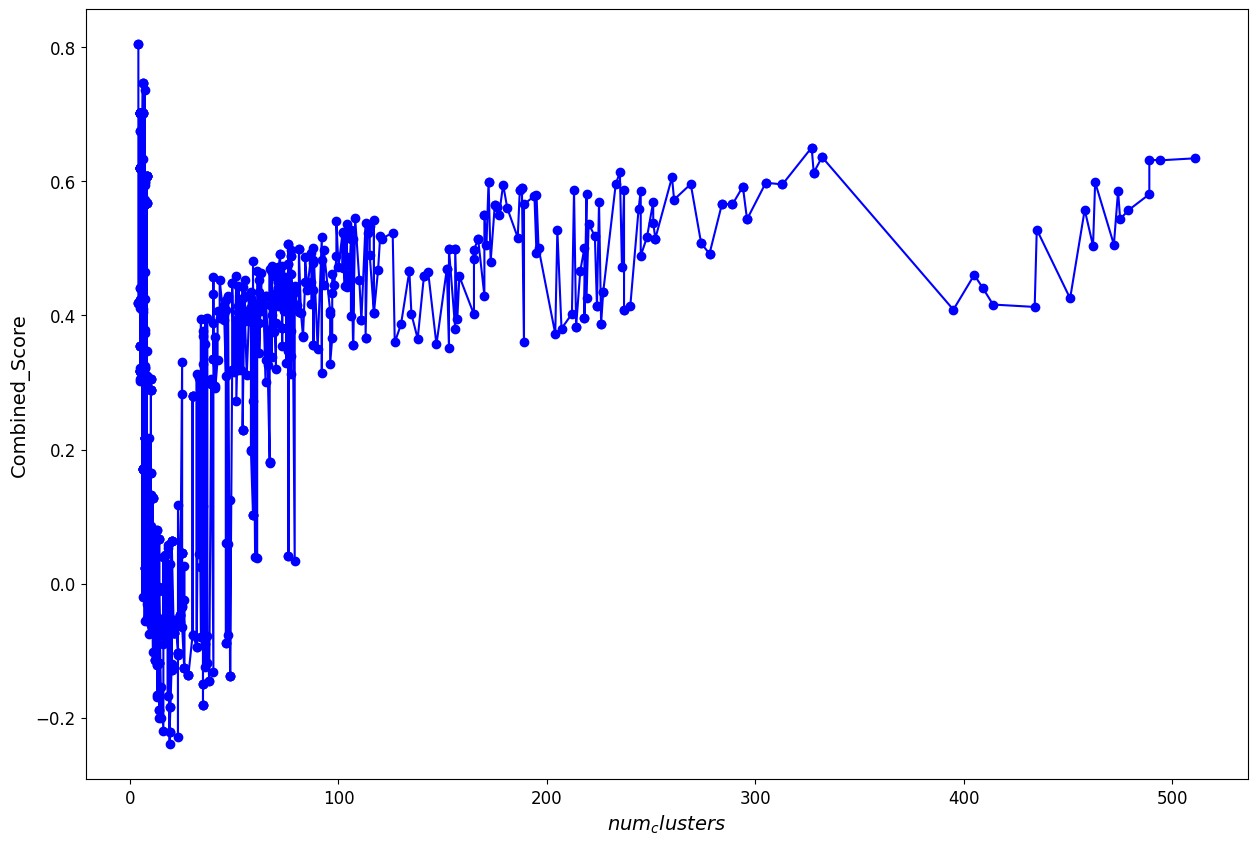

In [43]:
ordered_glove_df = glove_df.sort_values(by='CLUSTERS-NUM', ascending=True)
plt.figure(figsize=(15, 10))
plt.plot(ordered_glove_df['CLUSTERS-NUM'], ordered_glove_df['ORDERING_SCORE'], "bo-")
plt.xlabel("$num_clusters$", fontsize=14)
plt.ylabel("Combined_Score", fontsize=14)
plt.show()

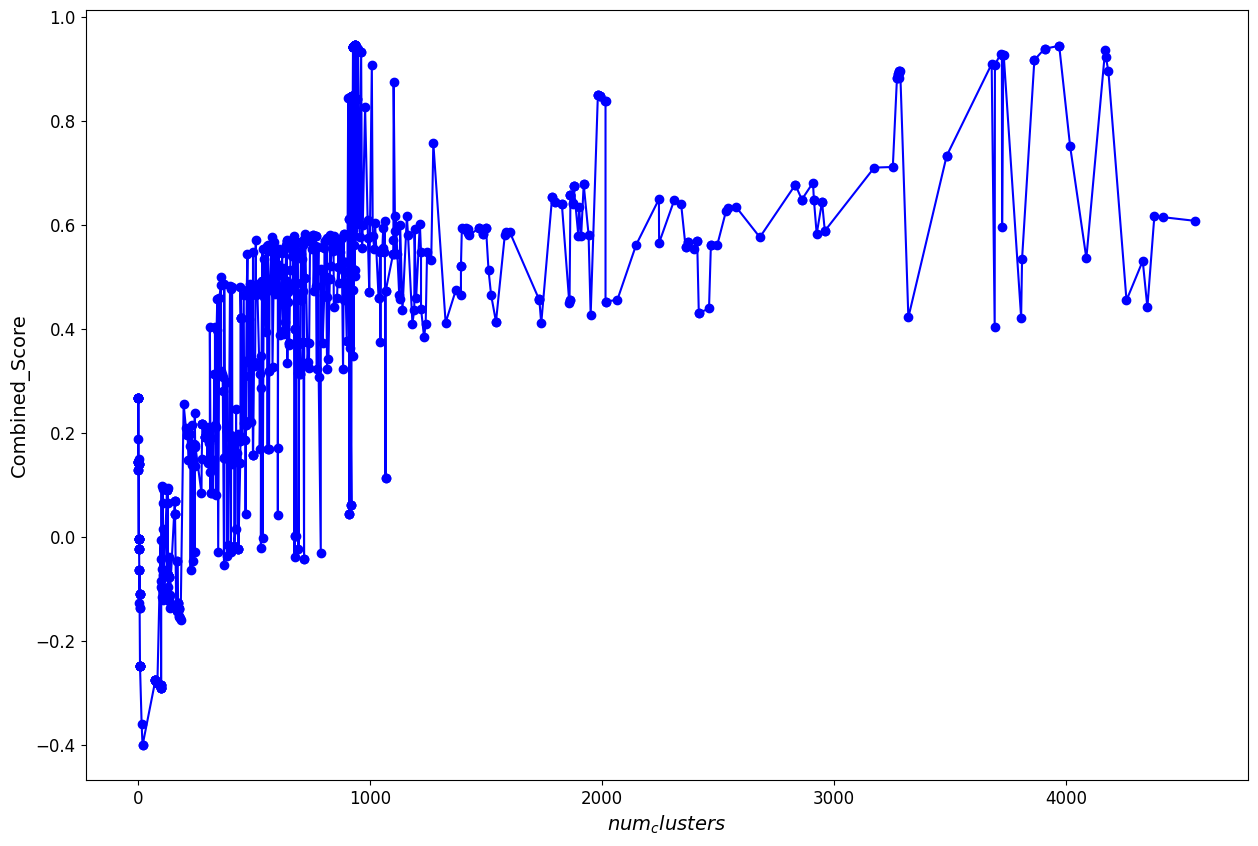

In [149]:
ordered_bert_df = bert_df.sort_values(by='CLUSTERS-NUM', ascending=True)
plt.figure(figsize=(15, 10))
plt.plot(ordered_bert_df['CLUSTERS-NUM'], ordered_bert_df['ORDERING_SCORE'], "bo-")
plt.xlabel("$num_clusters$", fontsize=14)
plt.ylabel("Combined_Score", fontsize=14)
plt.show()

## Describe and visualize the best UMAPs and clusterings ##

 ### filtering hyperparams based on score/num of cluster values ###

In [45]:
filtered_glove_df = glove_df[ (glove_df['embedding'] == 'glove-standardized') & (glove_df['UMAP-n_neighbors']<= 10) & (glove_df['UMAP-n_components']<= 3) & (glove_df['HDBSCAN-min_cluster_size']< 5) & (glove_df['HDBSCAN-cluster_selection_epsilon'] == 0.0)]


In [46]:
len(filtered_glove_df)

20



---





In [ ]:
for i,best_row in filtered_glove_df.iterrows():

  print(best_row)

  #embedding_type,n_neighbors,n_components,metric,min_dist

  umap_hyprparams_tuple = (best_row['embedding'],best_row['UMAP-n_neighbors'],best_row['UMAP-n_components'],best_row['UMAP-metric'],best_row['UMAP-min_dist'])

  best_clusterable_embedding = umap_embedding_map[umap_hyprparams_tuple]
  best_labels,best_clusterer_exemplars =   hdbscan_clustering_map[umap_hyprparams_tuple,best_row['HDBSCAN-min_cluster_size'],best_row['HDBSCAN-min_samples'],best_row['HDBSCAN-cluster_selection_epsilon']]
  map_instance_representative,map_cluster_representative = print_cluster_descriptions_frequency_for_hdbscan(best_labels,best_row['CLUSTERING-SILHOUETTE_CLUSTRED'],grouping_standardized,best_row,clustering_tests_tweets_glove)
  writeRelationMappingFile(clustering_tests_tweets_glove,best_row,map_instance_representative)
  visualizeClustering(best_row,best_clusterable_embedding,best_labels,grouping_standardized,clustering_tests_tweets_glove,map_cluster_representative )

In [ ]:
index_row_best_hyperparams =

In [ ]:
map_instance_representative

In [152]:
filtered_bert_df = bert_df[ (bert_df['embedding'] == 'bert-standardized') & (bert_df['HDBSCAN-cluster_selection_epsilon'] == 0.0) & (bert_df['UMAP-n_components']<= 3) & (bert_df['ORDERING_SCORE']>= 0.85)]

In [153]:
len(filtered_bert_df)

16

In [ ]:
filtered_bert_df['ORDERING_SCORE']

In [ ]:
for i,best_row in filtered_bert_df.iterrows():

  print(best_row)

  #embedding_type,n_neighbors,n_components,metric,min_dist

  umap_hyprparams_tuple = (best_row['embedding'],best_row['UMAP-n_neighbors'],best_row['UMAP-n_components'],best_row['UMAP-metric'],best_row['UMAP-min_dist'])

  best_clusterable_embedding = umap_embedding_map[umap_hyprparams_tuple]
  best_labels,best_clusterer_exemplars =   hdbscan_clustering_map[umap_hyprparams_tuple,best_row['HDBSCAN-min_cluster_size'],best_row['HDBSCAN-min_samples'],best_row['HDBSCAN-cluster_selection_epsilon']]
  map_instance_representative,map_cluster_representative = print_cluster_descriptions_frequency_for_hdbscan(best_labels,best_row['CLUSTERING-SILHOUETTE_CLUSTRED'],bert_relations,best_row,clustering_tests_tweets_bert)
  writeRelationMappingFile(clustering_tests_tweets_bert,best_row,map_instance_representative)
  visualizeClustering(best_row,best_clusterable_embedding,best_labels,bert_relations,clustering_tests_tweets_bert,map_cluster_representative)

In [171]:
filtered_bert_df_lower_clust_num = bert_df[ (bert_df['embedding'] == 'bert-standardized') & (bert_df['HDBSCAN-cluster_selection_epsilon'] == 0.0) & (bert_df['UMAP-n_components']<= 3) & (bert_df['CLUSTERS-NUM']< 920) & (bert_df['ORDERING_SCORE']>= 0.75)]
len(filtered_bert_df_lower_clust_num)

2

In [ ]:
for i,best_row in filtered_bert_df_lower_clust_num.iterrows():

  print(best_row)

  #embedding_type,n_neighbors,n_components,metric,min_dist

  umap_hyprparams_tuple = (best_row['embedding'],best_row['UMAP-n_neighbors'],best_row['UMAP-n_components'],best_row['UMAP-metric'],best_row['UMAP-min_dist'])

  best_clusterable_embedding = umap_embedding_map[umap_hyprparams_tuple]
  best_labels,best_clusterer_exemplars =   hdbscan_clustering_map[umap_hyprparams_tuple,best_row['HDBSCAN-min_cluster_size'],best_row['HDBSCAN-min_samples'],best_row['HDBSCAN-cluster_selection_epsilon']]
  map_instance_representative,map_cluster_representative = print_cluster_descriptions_frequency_for_hdbscan(best_labels,best_row['CLUSTERING-SILHOUETTE_CLUSTRED'],bert_relations,best_row,clustering_tests_tweets_bert)
  writeRelationMappingFile(clustering_tests_tweets_bert,best_row,map_instance_representative)
  visualizeClustering(best_row,best_clusterable_embedding,best_labels,bert_relations,clustering_tests_tweets_bert,map_cluster_representative)

## Load and add relation normalization column to the triple extraction file##

In [185]:
triples = pd.read_excel(os.path.join(clustering_shared_folder,'en_core_web_lg_preprocessing_depTrees_coref_multitoken100k.xlsx'), index_col=0, header=0)

In [186]:
len(triples)

29413

In [187]:
mapping_file = 'relation_mapping_100k_tweets_NUM_CLUSTERS:327UMAP_n_neighbors:5UMAP_n_components:2UMAP_metric:cosineUMAP_min_dist:0.0HDBSCAN-min_cluster_size:3HDBSCAN-min_samples:NoneHDBSCAN-cluster_selection_epsilon:0.0.csv'
with open(os.path.join(os.path.join(clustering_tests_tweets_glove,'relationMappings'),mapping_file), 'r') as infile:
  reader = csv.reader(infile)
  map_instance_representative = dict((rows[0],rows[1]) for rows in reader)

In [188]:
normalized_relations = [ map_instance_representative[str(rel).lower()] if str(rel).lower() in map_instance_representative.keys() else 'None' for rel in  triples['triple_rel'] ]

In [189]:
triples['normalized_relations'] = normalized_relations

In [191]:
triples.to_excel(os.path.join(clustering_shared_folder,'en_core_web_lg_preprocessing_depTrees_coref_multitoken100k_NormalizedRelations.xlsx'), encoding="utf-8", engine="xlsxwriter")
